In [18]:
import numpy as np

In [19]:
data = np.load(r"C:\Users\DELL\Downloads\IMERG_Senegal_1h_JJASO.npz")

In [27]:
print(data.files)

['data', 'lat', 'lon']


<a href="https://colab.research.google.com/github/mdiallofzj/APARC_AI4Climate_School_2025/blob/main/Hands-on/SummerSchool_WCRP_Simple_Downscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Downscaling with U-Net: Part 1 (perfect setting - simple)

*Author: Redouane Lguensat (IPSL/IRD)*

**Goal**: Learn how to use Deep Learning (specifically U-Net) to downscale low-resolution precipitation data to high-resolution.

**Problem**: We have coarse-grained precipitation data (e.g., from satellite or climate models) and we want to infer the fine-grained details. This is an "Inverse Problem". But to make things simple, the coarsened and fine scale data are from the same source.

**Method**: We will train a Convolutional Neural Network (U-Net) to map:
$$ X_{\text{coarse}} \rightarrow Y_{\text{fine}} $$

**Dataset**: IMERG Precipitation data over Senegal (Hourly, JJASO months) which is around 88K samples


In [ ]:
# Environment setup (works on Colab and local Jupyter)
import sys, os
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab.")
else:
    print("Not running in Google Colab.")

def show_install_instructions():
    """Prints installation commands for Windows (cmd.exe) and a helper to install inside the notebook."""
    print("To install required packages in Windows cmd.exe:")
    print(r"python -m pip install -r requirements.txt")
    print()
    print("If you prefer individual packages (may require extra system deps for cartopy):")
    print(r"python -m pip install numpy matplotlib shapely cartopy")
    print(r"For PyTorch, please use the installer at https://pytorch.org/get-started/locally/ (choose the correct CUDA/cpu build)")
    print()
    print("To install directly from this notebook (uses the current Python interpreter):")
    print(r"import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', 'requirements.txt'])")

print("Environment helper loaded. Call show_install_instructions() to see install commands.")

Running in Google Colab. Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Created wheel for shapely: filename=shapely-2.1.2-cp312-cp312-linux_x86_64.whl size=1272074 sha256=4e89ed460325f89f322bc0e4a690048c704efdf617a42da224a60cc6260bc36c
  Stored in directory: /root/.cache/pip/wheels/e9/38/c7/6f4f8e2dc4abc29e31467a46546a15559efb2b735ab460b46d
Successfully built shapely
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.2
    Un

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 109.0 MB/s eta 0:00:00


In [4]:
pip install numpy matplotlib torch torchvision cartopy shapely jupyter ipykernel

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
      --------------------------------------- 0.3/10.8 MB ? eta -:--:--
      --------------------------------------- 0.3/10.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/10.8 MB 710.5 kB/s eta 0:00:15
     -- ------------------------------------ 0.8/10.8 MB 799.6 kB/s eta 0:00:13
     --- ----------------------------------- 1.0/10.8 MB 817.5 kB/s eta 0:00:12
     --- ----------------------------------- 1.0/10.8 MB 817.5 kB/s eta 0:00:12
     ---- ---------------------------------- 1.3/10.8 MB 831.9 kB/s eta 0:00:12
     ----- --------------------------------- 1.6/10.8 MB 854.1 kB/s eta 0:00:11
     ------ -------------------------------- 1.8/10.8 MB 869.4 kB/s eta 0:00:11
  

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported.")

Libraries imported.


In [6]:
# GPU check (works in Jupyter without shell commands)
try:
    if torch.cuda.is_available():
        print(f"CUDA available. Device count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            try:
                print(f"Device {i}: {torch.cuda.get_device_name(i)}")
            except Exception:
                pass
    else:
        print("CUDA not available.")
except Exception as e:
    print("Could not query CUDA status:", e)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA not available.
Using device: cpu


## 1. Data Loading
We load the hourly IMERG precipitation data.
- **Input**: Coarse resolution (32x32)
- **Target**: Fine resolution (64x64)

*Note: We simulate the coarse data by degrading the fine data.*

In [7]:
# Data path: set to your local file provided
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
# Update this path if your file is located elsewhere on disk
precip_path = r"C:\Users\DELL\Downloads\IMERG_Senegal_1h_JJASO.npz"

if not os.path.exists(precip_path):
    print(f"Data file not found at {precip_path}.")
    print("Please put the file at that path or update the `precip_path` variable accordingly.")
else:
    print(f"Using data file: {precip_path}")

Using data file: C:\Users\DELL\Downloads\IMERG_Senegal_1h_JJASO.npz


In [9]:
# Load data (uses `precip_path` defined above)
if not os.path.exists(precip_path):
    raise FileNotFoundError(f"Data file not found at {precip_path}. Update `precip_path` to the correct location.")

precip_npz = np.load(precip_path, allow_pickle=True)
# Try common array names (fallbacks included)
if 'data' in precip_npz:
    precip_all = precip_npz['data']
elif 'precip' in precip_npz:
    precip_all = precip_npz['precip']
else:
    # If the NPZ stores a single unnamed array, try loading the first item
    keys = list(precip_npz.files)
    if len(keys) > 0:
        precip_all = precip_npz[keys[0]]
    else:
        raise KeyError("No arrays found in the NPZ file.")

# Get coordinates if present (fallback to simple ranges)
# Use explicit membership checks to avoid ambiguous truth-value for arrays
if 'lon' in precip_npz:
    lon_fine = precip_npz['lon']
elif 'lon_fine' in precip_npz:
    lon_fine = precip_npz['lon_fine']
else:
    lon_fine = None

if 'lat' in precip_npz:
    lat_fine = precip_npz['lat']
elif 'lat_fine' in precip_npz:
    lat_fine = precip_npz['lat_fine']
else:
    lat_fine = None

# Validate shape: expected (time, H, W)
if precip_all.ndim != 3:
    raise ValueError(f"Unexpected precip array shape {precip_all.shape}. Expected (time, H, W).")
n_time, H, W = precip_all.shape
if lon_fine is None or lat_fine is None:
    print("Longitude/latitude arrays not found in NPZ. Using simple indices as coordinates.")
    lon_fine = np.arange(W)
    lat_fine = np.arange(H)

print(f"Original Data Shape: {precip_all.shape}")
print(f"Coords Shape: {lon_fine.shape}, {lat_fine.shape}")

# Create Coarse Data by block-averaging. We target a 16x16 coarse grid from the fine grid.
# Compute block factors dynamically in case H/W != 64
factor_h = H // 16
factor_w = W // 16
if factor_h < 1 or factor_w < 1:
    raise ValueError("Data too small to create 16x16 coarse grid.")
# If H or W are not exact multiples, we'll trim the array to the largest divisible shape
H_trim = factor_h * 16
W_trim = factor_w * 16
if H_trim != H or W_trim != W:
    print(f"Trimming data from (H,W)=({H},{W}) to ({H_trim},{W_trim}) to form regular blocks.")
    precip_all = precip_all[:, :H_trim, :W_trim]
    lon_fine = lon_fine[:W_trim]
    lat_fine = lat_fine[:H_trim]
    n_time, H, W = precip_all.shape

precip_coarse = precip_all.reshape(n_time, 16, factor_h, 16, factor_w).mean(axis=(2, 4))

# Create coarse coords by averaging blocks
lon_coarse = lon_fine.reshape(16, factor_w).mean(axis=1)
lat_coarse = lat_fine.reshape(16, factor_h).mean(axis=1)

print(f"Coarse Data Shape: {precip_coarse.shape}")
print(f"Coarse Coords Shape: {lon_coarse.shape}, {lat_coarse.shape}")

Original Data Shape: (88128, 64, 64)
Coords Shape: (64,), (64,)
Coarse Data Shape: (88128, 16, 16)
Coarse Coords Shape: (16,), (16,)
Coarse Data Shape: (88128, 16, 16)
Coarse Coords Shape: (16,), (16,)


## 2. Exploratory Data Analysis (EDA)
Let's visualize the difference between the coarse input and the fine target.


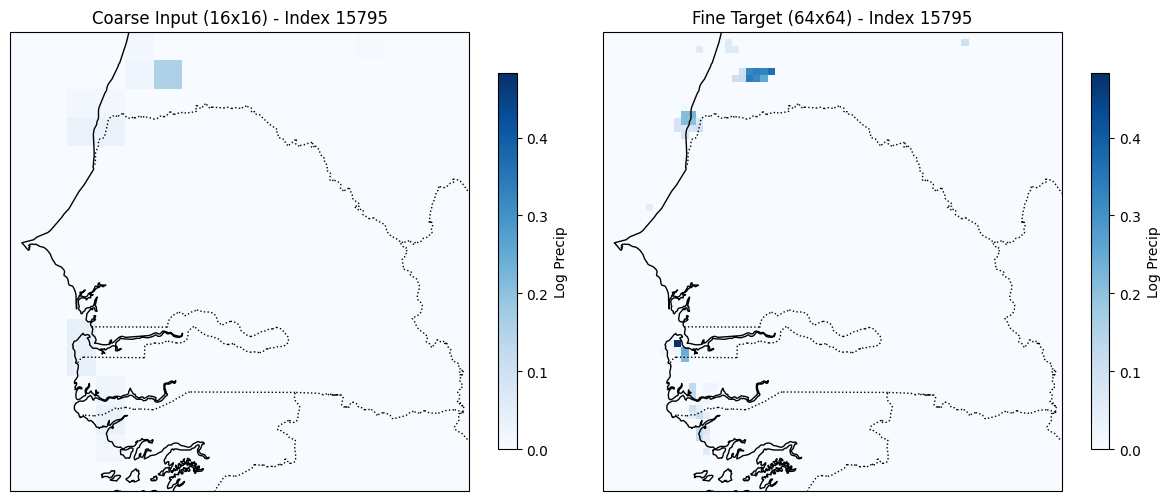

In [10]:
def plot_example(coarse_data, fine_data, lon_c, lat_c, lon_f, lat_f, idx=None):
    if idx is None:
        idx = np.random.randint(0, coarse_data.shape[0])

    fig = plt.figure(figsize=(12, 5))

    # Compute common vmin/vmax for fair comparison
    data_min = min(np.log1p(coarse_data[idx]).min(), np.log1p(fine_data[idx]).min())
    data_max = max(np.log1p(coarse_data[idx]).max(), np.log1p(fine_data[idx]).max())

    # Coarse
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_title(f"Coarse Input (16x16) - Index {idx}")
    # pcolormesh needs 2D coords or 1D coords matching dimensions.
    # Our lon_c/lat_c are 1D, so we can pass them directly.
    im1 = ax1.pcolormesh(lon_c, lat_c, np.log1p(coarse_data[idx]), cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=data_min, vmax=data_max)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im1, ax=ax1, label='Log Precip', orientation='vertical', shrink=0.8)

    # Fine
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_title(f"Fine Target (64x64) - Index {idx}")
    im2 = ax2.pcolormesh(lon_f, lat_f, np.log1p(fine_data[idx]), cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=data_min, vmax=data_max)
    ax2.add_feature(cfeature.COASTLINE)
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im2, ax=ax2, label='Log Precip', orientation='vertical', shrink=0.8)

    plt.tight_layout()
    plt.show()

# Show a random example
plot_example(precip_coarse, precip_all, lon_coarse, lat_coarse, lon_fine, lat_fine)

## 3. Data Preprocessing
1.  **Split**: Train (2001-2020), Validation (2021-2022), Test (2023-2024), but reminder it's only JJASO months
2.  **Normalization**: We use `log1p` (log(1+x)) to handle the heavy-tailed distribution of precipitation.
3.  **Thresholding**: We set very small values (< 0.1 mm) to 0.


In [11]:
# Configuration
WET_THRESHOLD = 0.1
BATCH_SIZE = 32

# Split
n_total = precip_all.shape[0]
n_holdout = int(n_total * (1/6)) # Approx last 4 years
mid_holdout = n_holdout // 2

# Indices
idx_train_end = n_total - n_holdout
idx_val_end = n_total - mid_holdout

# Raw Split
Y_train_raw = precip_all[:idx_train_end]
X_train_raw = precip_coarse[:idx_train_end]

Y_val_raw = precip_all[idx_train_end:idx_val_end]
X_val_raw = precip_coarse[idx_train_end:idx_val_end]

Y_test_raw = precip_all[idx_val_end:]
X_test_raw = precip_coarse[idx_val_end:]

print(f"Train: {X_train_raw.shape[0]} samples")
print(f"Val  : {X_val_raw.shape[0]} samples")
print(f"Test : {X_test_raw.shape[0]} samples")

# Preprocessing Function
def preprocess(X, Y, threshold=0.1):
    # Thresholding
    X[X < threshold] = 0
    Y[Y < threshold] = 0

    # Log Transform
    X_log = np.log1p(X)
    Y_log = np.log1p(Y)

    # Add Channel Dimension (N, H, W) -> (N, 1, H, W)
    X_log = X_log[:, None, :, :]
    Y_log = Y_log[:, None, :, :]

    return X_log, Y_log

# Apply Preprocessing
X_train, Y_train = preprocess(X_train_raw, Y_train_raw, WET_THRESHOLD)
X_val, Y_val = preprocess(X_val_raw, Y_val_raw, WET_THRESHOLD)
X_test, Y_test = preprocess(X_test_raw, Y_test_raw, WET_THRESHOLD)

# Clean up raw data to save memory
del precip_all, precip_coarse, X_train_raw, Y_train_raw, X_val_raw, Y_val_raw, X_test_raw, Y_test_raw

Train: 73440 samples
Val  : 7344 samples
Test : 7344 samples


## 4. U-Net Architecture
The U-Net is an encoder-decoder architecture with skip connections.
- **Encoder**: Downsamples the image, capturing context.
- **Decoder**: Upsamples the features, localizing the output.
- **Skip Connections**: Preserve spatial information lost during downsampling.

We define a flexible `UnetPr` class.


In [12]:
class UnitConv(nn.Module):
    """
    Basic Convolution Block: Conv2d -> BatchNorm -> ReLU -> Conv2d -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, batch_norm=True):
        super().__init__()
        layers = []
        # First Conv
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=not batch_norm))
        if batch_norm: layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        # Second Conv
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding, bias=not batch_norm))
        if batch_norm: layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class UpLayer(nn.Module):
    """
    Upsampling Block: Transposed Conv or Bilinear Upsample + Conv
    """
    def __init__(self, in_channels, out_channels, trans_conv=True):
        super().__init__()
        if trans_conv:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        else:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            )

    def forward(self, x):
        return self.up(x)

class UnetPr(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base=32, batch_norm=True):
        super().__init__()

        # Encoder
        self.enc1 = UnitConv(in_channels, base, batch_norm=batch_norm)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = UnitConv(base, base*2, batch_norm=batch_norm)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = UnitConv(base*2, base*4, batch_norm=batch_norm)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = UnitConv(base*4, base*8, batch_norm=batch_norm)
        self.pool4 = nn.MaxPool2d(2) # This takes 32x32 -> 2x2

        # Bottleneck
        self.center = UnitConv(base*8, base*16, batch_norm=batch_norm)

        # Decoder
        self.dec4 = UpLayer(base*16, base*8)
        self.conv4 = UnitConv(base*16, base*8, batch_norm=batch_norm) # 8 from up + 8 from skip

        self.dec3 = UpLayer(base*8, base*4)
        self.conv3 = UnitConv(base*8, base*4, batch_norm=batch_norm)

        self.dec2 = UpLayer(base*4, base*2)
        self.conv2 = UnitConv(base*4, base*2, batch_norm=batch_norm)

        self.dec1 = UpLayer(base*2, base)
        self.conv1 = UnitConv(base*2, base, batch_norm=batch_norm)

        # Final Upsample to 64x64 (Super-resolution step)
        # Input is 16x16. We need 2 upsamples to get to 64x64.
        self.final_up1 = UpLayer(base, base)
        self.final_up2 = UpLayer(base, base)
        self.final_conv = nn.Conv2d(base, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        c = self.center(p4)

        # Decoder
        d4 = self.dec4(c)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.conv4(d4)

        d3 = self.dec3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.conv3(d3)

        d2 = self.dec2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.conv2(d2)

        d1 = self.dec1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.conv1(d1)

        # Final Upsample to 64x64
        out = self.final_up1(d1) # 16 -> 32
        out = self.final_up2(out) # 32 -> 64
        out = self.final_conv(out)

        return out

print("Model defined.")

Model defined.


## 5. Training Loop
We define the DataLoaders, Loss Function (L1 Loss), and Optimizer (AdamW).


In [13]:
# Datasets
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Model Init
model = UnetPr(in_channels=1, out_channels=1, base=32).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.L1Loss()

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Parameters: 7,770,721


In [14]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

# Training
EPOCHS = 20
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_unet.pth')
        print(f"Epoch {epoch+1}/{EPOCHS} - Train: {train_loss:.4f} - Val: {val_loss:.4f} (New Best!)")
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} - Train: {train_loss:.4f} - Val: {val_loss:.4f}")

Starting training...


C:\Users\DELL\AppData\Roaming\Python\Python314\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/20 - Train: 0.0288 - Val: 0.0268 (New Best!)
Epoch 2/20 - Train: 0.0262 - Val: 0.0268 (New Best!)
Epoch 2/20 - Train: 0.0262 - Val: 0.0268 (New Best!)
Epoch 3/20 - Train: 0.0259 - Val: 0.0266 (New Best!)
Epoch 3/20 - Train: 0.0259 - Val: 0.0266 (New Best!)
Epoch 4/20 - Train: 0.0258 - Val: 0.0274
Epoch 4/20 - Train: 0.0258 - Val: 0.0274
Epoch 5/20 - Train: 0.0255 - Val: 0.0275
Epoch 5/20 - Train: 0.0255 - Val: 0.0275
Epoch 6/20 - Train: 0.0255 - Val: 0.0275
Epoch 6/20 - Train: 0.0255 - Val: 0.0275
Epoch 7/20 - Train: 0.0253 - Val: 0.0272
Epoch 7/20 - Train: 0.0253 - Val: 0.0272
Epoch 8/20 - Train: 0.0253 - Val: 0.0268
Epoch 8/20 - Train: 0.0253 - Val: 0.0268
Epoch 9/20 - Train: 0.0253 - Val: 0.0261 (New Best!)
Epoch 9/20 - Train: 0.0253 - Val: 0.0261 (New Best!)
Epoch 10/20 - Train: 0.0252 - Val: 0.0261 (New Best!)
Epoch 10/20 - Train: 0.0252 - Val: 0.0261 (New Best!)
Epoch 11/20 - Train: 0.0251 - Val: 0.0259 (New Best!)
Epoch 11/20 - Train: 0.0251 - Val: 0.0259 (New Best!)
Epo

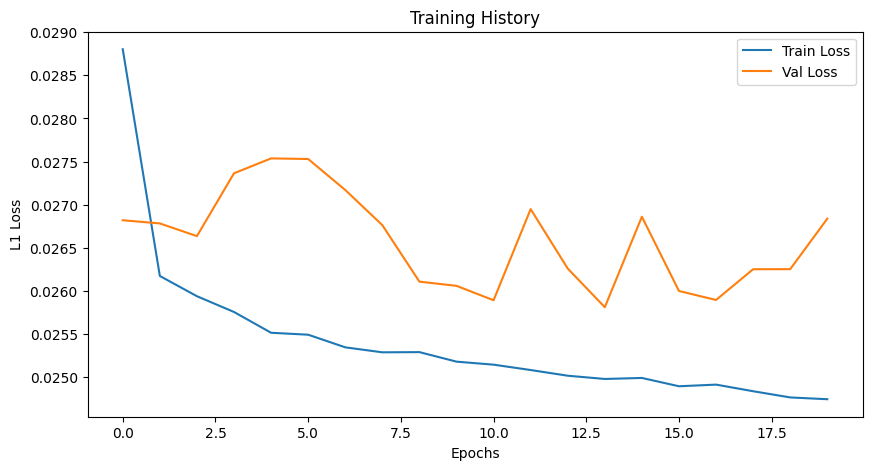

In [15]:
# Plot History
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.title('Training History')
plt.show()

## 6. Evaluation
Let's check the model performance on the test set.


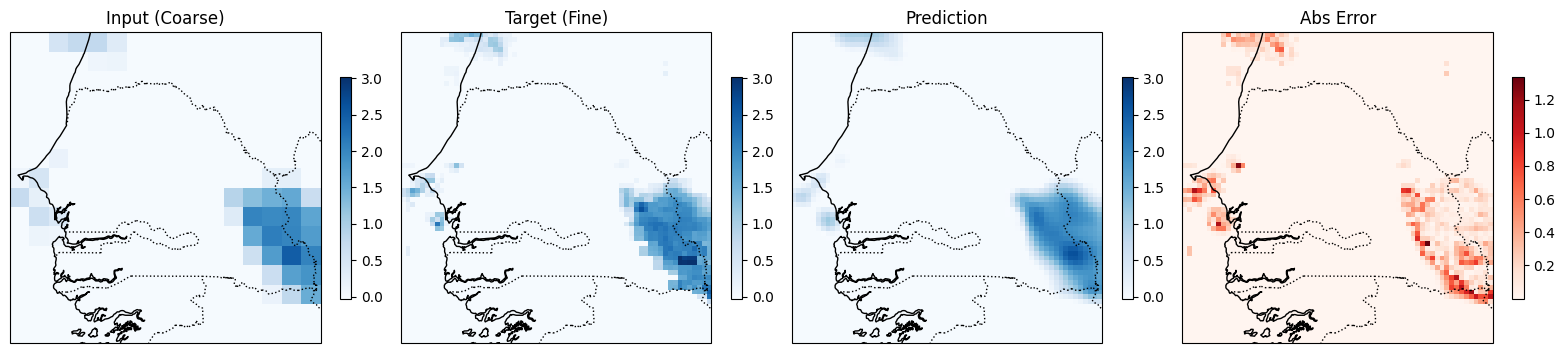

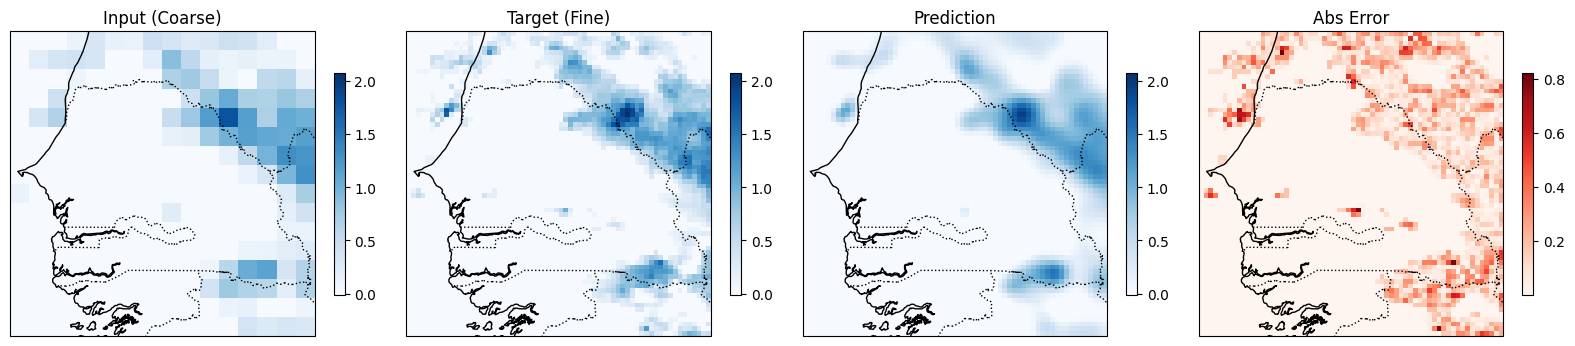

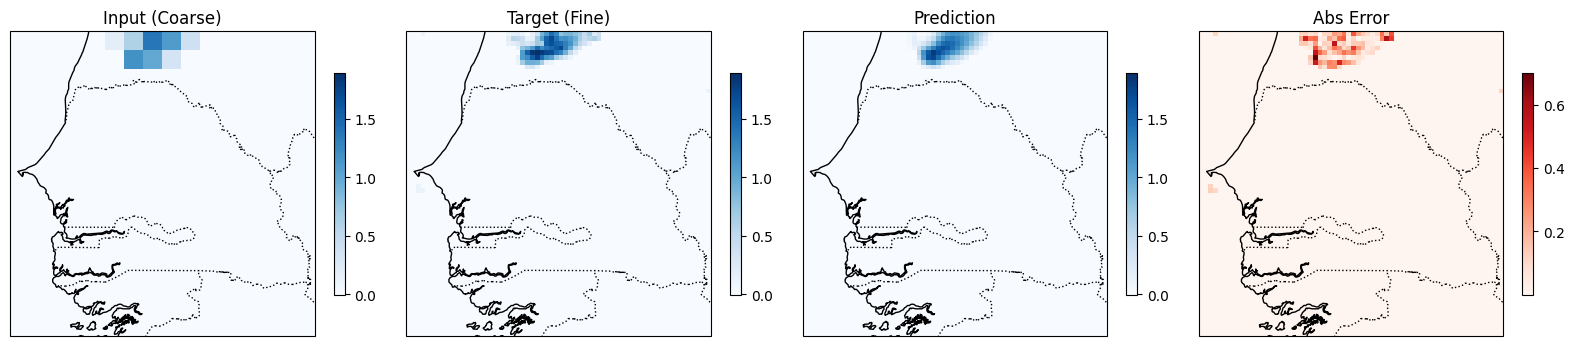

In [16]:
# Load Best Model
model.load_state_dict(torch.load('best_unet.pth'))
model.eval()

# Pick random test samples
indices = np.random.choice(len(test_dataset), 3, replace=False)

for idx in indices:
    x, y = test_dataset[idx]
    x_in = x.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x_in).cpu().squeeze().numpy()

    x_np = x.squeeze().numpy()
    y_np = y.squeeze().numpy()

    fig = plt.figure(figsize=(16, 4))

    # Compute common vmin/vmax for Input, Target, Prediction
    vmin = min(x_np.min(), y_np.min(), pred.min())
    vmax = max(x_np.max(), y_np.max(), pred.max())

    # Input
    ax1 = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
    ax1.set_title("Input (Coarse)")
    im1 = ax1.pcolormesh(lon_coarse, lat_coarse, x_np, cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im1, ax=ax1, shrink=0.6)

    # Target
    ax2 = fig.add_subplot(1, 4, 2, projection=ccrs.PlateCarree())
    ax2.set_title("Target (Fine)")
    im2 = ax2.pcolormesh(lon_fine, lat_fine, y_np, cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax2.add_feature(cfeature.COASTLINE)
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im2, ax=ax2, shrink=0.6)

    # Prediction
    ax3 = fig.add_subplot(1, 4, 3, projection=ccrs.PlateCarree())
    ax3.set_title("Prediction")
    im3 = ax3.pcolormesh(lon_fine, lat_fine, pred, cmap='Blues', shading='nearest', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax3.add_feature(cfeature.COASTLINE)
    ax3.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im3, ax=ax3, shrink=0.6)

    # Error
    ax4 = fig.add_subplot(1, 4, 4, projection=ccrs.PlateCarree())
    ax4.set_title("Abs Error")
    im4 = ax4.pcolormesh(lon_fine, lat_fine, np.abs(y_np - pred), cmap='Reds', shading='nearest', transform=ccrs.PlateCarree())
    ax4.add_feature(cfeature.COASTLINE)
    ax4.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(im4, ax=ax4, shrink=0.6)

    plt.tight_layout()
    plt.show()